In [1]:
import os
os.chdir("../../../../")

In [2]:
import matplotlib.pyplot as plt
from utilities import plot,errors
import pandas as pd
from utilities.recalibration import *
from sklearn.isotonic import IsotonicRegression
import jax
import jax.numpy as jnp

In [4]:
training_predictions_df=pd.read_csv("notebooks/fridge/s2p/gmlp/training_predictions.csv")
testing_predictions_df = pd.read_csv("notebooks/fridge/s2p/gmlp/testing_predictions.csv")
cal_predictions_df= pd.read_csv("notebooks/fridge/s2p/gmlp/calibration_predictions.csv")

In [5]:
y_train=training_predictions_df['Ground Truth']
train_mean=training_predictions_df['mean']
train_sigma=training_predictions_df['sigma']
mc_train_mean=training_predictions_df['MC_mean']
mc_train_sigma=training_predictions_df['MC_sigma']
de_train_mean=training_predictions_df['DE_mean']
de_train_sigma=training_predictions_df['DE_sigma']
bs_train_mean=training_predictions_df['BS_mean']
bs_train_sigma=training_predictions_df['BS_sigma']

y_cal=cal_predictions_df['Ground Truth']
cal_mean=cal_predictions_df['mean']
cal_sigma=cal_predictions_df['sigma']
mc_cal_mean=cal_predictions_df['MC_Mean']
mc_cal_sigma=cal_predictions_df['MC_Sigma']
de_cal_mean=cal_predictions_df['DE_mean']
de_cal_sigma=cal_predictions_df['DE_sigma']
bs_cal_mean=cal_predictions_df['bs_Mean']
bs_cal_sigma=cal_predictions_df['bs_Sigma']

y_test=testing_predictions_df['Ground Truth']
test_mean=testing_predictions_df['mean']
test_sigma=testing_predictions_df['sigma']
mc_test_mean=testing_predictions_df['MC_Mean']
mc_test_sigma=testing_predictions_df['MC_Sigma'] 
de_test_mean=testing_predictions_df['de_Mean']
de_test_sigma=testing_predictions_df['de_Sigma']
bs_test_mean=testing_predictions_df['bs_Mean']
bs_test_sigma=testing_predictions_df['bs_Sigma']

In [6]:
def ace(ideal,predicted):
    """
    dataframe : pandas dataframe with Ideal and Counts as column for regression calibration
    It can be directly used as 2nd output from calibration_regression in plot.py 
    """
    def rmse_loss(y,yhat):
      return jnp.abs(y-yhat)
    return jnp.mean(jax.vmap(rmse_loss,in_axes=(0,0))(ideal,predicted))
    # return(jnp.sum(jnp.abs(dataframe['Ideal'].values-dataframe['Counts'].values)))


In [7]:
# For saving
recalibration_df = pd.DataFrame()

## Single


In [8]:
def find_p_hat_(y, mean_prediction,std_prediction):
    out = {}
    for mass in np.linspace(1e-10, 1-1e-20, 1000):
    #for mass in jnp.arange(0, 1.1, 0.1):
        out[mass] = plot_find_p(y, mean_prediction,std_prediction, mass)[1]
    df = pd.Series(out).to_frame()
    df.index.name = 'p'
    df.columns = ['p_hat']
    # df=df.reset_index()
    return df

In [9]:
series_train = find_p_hat_(y_train,train_mean,train_sigma)
series_test = find_p_hat_(y_test,test_mean,test_sigma)
series_cal= find_p_hat_(y_cal,cal_mean,cal_sigma)
p=series_cal.index
recalibration_df["p"] = p

In [10]:
series_cal.values.shape

(1000, 1)

In [11]:
calibrator = IsotonicRegression(out_of_bounds='clip')
calibrator.fit(series_cal.values,series_cal.index)
new_p=calibrator.predict(series_cal.index)

In [12]:
new_p_hat_train=find_new_p_hat(y_train,new_p,train_mean,train_sigma)
new_p_hat_cal=find_new_p_hat(y_cal,new_p,cal_mean,cal_sigma)
new_p_hat_test=find_new_p_hat(y_test,new_p,test_mean,test_sigma)

In [13]:
import seaborn as sns
from probml_utils import latexify,savefig

In [14]:
import os
os.environ['LATEXIFY']='1'
os.environ['FIG_DIR']='FIGURES/'
latexify(fig_height=7/3,fig_width=7/1.8)

<Figure size 280x168 with 0 Axes>

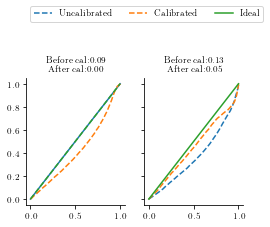

In [15]:

plt.figure()
# plt.subplot(1,3,1)
# plt.plot(p, series_train.values, label='Uncalibrated')
# plt.plot(p, new_p_hat_train, label='Calibrated')
# plt.plot([0, 1], [0, 1], label="Ideal")
# plt.title(f"Train Data: Before cal:{ace(p.values,series_train.values):2f} After cal:{ace(p.values,new_p_hat_train):2f}")
# plt.legend()

fig, (a,b)=plt.subplots(1,2,sharey='row')
a.plot([0, 1], [0, 1], label="Ideal")
a.plot(p, series_cal.values, label='Uncalibrated', linestyle='dashed')
a.plot(p, new_p_hat_cal, label='Calibrated', linestyle='dashed')
# a.plot([0, 1], [0, 1], label="Ideal")
a.set_title(f"Before cal:{ace(p.values,series_cal.values):.2f}\n After cal:{ace(p.values,new_p_hat_cal):.2f}")
# b.legend(bbox_to_anchor=(1.5,1.7),ncol=3)
# a.ylim([0,1])
# a.xlim([0,1])
# plt.subplot(1,3,3)
b.plot(p, series_test.values, label='Uncalibrated', linestyle='dashed')
b.plot(p, new_p_hat_test,label='Calibrated', linestyle='dashed')
b.plot([0, 1], [0, 1], label="Ideal")
b.set_title(f"Before cal:{ace(p.values,series_test.values):.2f}\n After cal:{ace(p.values,new_p_hat_test):.2f}")
# b.legend()
# b.ylim([0,1])
# b.xlim([0,1])
b.legend(bbox_to_anchor=(1.25,1.6),ncol=3)
sns.despine()

In [16]:
recalibration_df["phat"] = series_test.values
recalibration_df["new_p"] = new_p
recalibration_df["new_phat"] = new_p_hat_test

## MC Dropout

In [17]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [18]:
series_train = find_p_hat_(y_train,mc_train_mean,mc_train_sigma)
series_test = find_p_hat_(y_test,mc_test_mean,mc_test_sigma)
series_cal= find_p_hat_(y_cal,mc_cal_mean,mc_cal_sigma)
p=series_cal.index
recalibration_df["p"] = p

In [19]:
calibrator_mc = IsotonicRegression(out_of_bounds='clip')
calibrator_mc.fit(series_cal.values,series_cal.index)
new_p=calibrator_mc.predict(series_cal.index)

In [20]:
new_p_hat_train=find_new_p_hat(y_train,new_p,mc_train_mean,mc_train_sigma)
new_p_hat_cal=find_new_p_hat(y_cal,new_p,mc_cal_mean,mc_cal_sigma)
new_p_hat_test=find_new_p_hat(y_test,new_p,mc_test_mean,mc_test_sigma)

In [21]:
dataframe_recal=pd.read_csv('notebooks/fridge/s2p/gmlp/recalibration_df.csv')
dataframe_test=pd.read_csv('notebooks/fridge/s2p/gmlp/testing_predictions.csv') 

In [22]:
dataframe_recal.columns = map(str.lower, dataframe_recal.columns)
dataframe_test.columns = map(str.lower, dataframe_test.columns)

In [23]:
jax.__version__

'0.3.13'

In [39]:
def load_model(recab):
    p=recab['p'].iloc[949]
    new_p=recab['new_p_mc'].iloc[949]
    ori_std_factor=mass_to_std_factor(p)
    new_std_factor=mass_to_std_factor(new_p)
    return ori_std_factor,new_std_factor

def plot(timestamp, gt, mean, sigma, ori_std_factor, new_std_factor, idx1, idx2, p, p_hat, new_phat):
    
    fig,(ax1,ax2)=plt.subplots(1,2,sharey='row')
    idx = jnp.where(
        (gt.values < mean.values + ori_std_factor * sigma.values)
        & (gt.values > mean.values - ori_std_factor * sigma.values)
    )[0]
    print(len(idx))
    ax1.plot(timestamp, gt.values, label="Ground Truth")
    ax1.plot(timestamp, mean.values, label="Mean",color="black")
    ax1.fill_between(
        timestamp,
        mean.values - ori_std_factor * sigma.values,
        mean.values + ori_std_factor * sigma.values,
        label=r"95\%",
        alpha=0.2,
        color="C1"
    )
    print(idx)
    ax1.scatter(timestamp.values[np.array(idx)], gt[jnp.arange(idx1,idx2)[idx]], label="Within", color="C1",s=10)
    # ax1.legend(
    #     ncol=2,
    #     bbox_to_anchor=(1.01, 1.4),
    #     fontsize=6
    # )
    h = ax1.legend(["Ground\nTruth", "Mean"], loc="upper right", fontsize=6)

    # ax1.add_artist(h)
    # red_patch = mpatches.Patch(color='C1',alpha=0.2, label='95\%')
    # nine = mlines.Line2D([], [], color='C1', marker='o', ls='', label='Within', markersize=6)
    # h = ax1.legend(handles=[red_patch, nine], loc="upper right", fontsize=6)
    # ax1.text(-1,-4,'(b) Before Cal.')

    ax1.set_xticks(jnp.arange(0, idx2-idx1, 50), fontsize=2)
    ax1.tick_params(axis='x',rotation=60)

    
    idx = jnp.where(
        (gt.values < mean.values + new_std_factor * sigma.values)
        & (gt.values > mean.values - new_std_factor * sigma.values)
    )[0]
    print(len(idx))
    ax2.plot(timestamp ,gt.values, label="Ground Truth")
    ax2.plot(timestamp, mean.values, label="Mean prediction",color="black")
    ax2.fill_between(
        timestamp,
        mean.values - new_std_factor * sigma.values,
        mean.values + new_std_factor * sigma.values,
        #label=rf"{100*mass:0.2f}% CI, $\mu \pm {std_factor:0.2f}\sigma$",
        alpha=0.2,
        color="C1"
    )
    ax2.scatter(timestamp.values[np.array(idx)], gt[jnp.arange(idx1,idx2)[idx]], label="Within", color="C1",s=10)
    ax2.set_xticks(jnp.arange(0, idx2-idx1, 50))
    ax2.tick_params(axis='x',rotation=60)
    red_patch = mpatches.Patch(color='C1',alpha=0.2, label='95\%')
    nine = mlines.Line2D([], [], color='C1', marker='o', ls='', label='Within', markersize=6)
    h = ax2.legend(handles=[red_patch, nine], loc="upper right", fontsize=6)

    

    ax1.set_ylabel('Power (W)')
    ax2.set_title("\% of points within CI:84\%")
    ax1.set_title("\% of points within CI:90\%")
    ax1.set_xlabel('(a) Before Cal.')
    ax2.set_xlabel('(b) After Cal.')
    # ax2.text(-1,-4,'(b) After Cal.')
    sns.despine()

224
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  86  96 106 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 173 174 175 176 177 178 179 180 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241
 242 243 244 245 246 247 248 249]
210


/tmp/ipykernel_829/3710160740.py:41: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax1.set_xticks(jnp.arange(0, idx2-idx1, 50), fontsize=2)
/tmp/ipykernel_829/3710160740.py:61: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax2.set_xticks(jnp.arange(0, idx2-idx1, 50))


saving image to FIGURES/badcalnew_latexified.pdf
Figure size: [3.88888889 2.33333333]


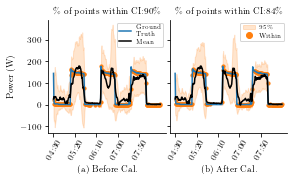

In [40]:
recal=dataframe_recal
test=dataframe_test
idx1=3150
idx2=3400

timestamp = dataframe_test["timestamp"][idx1:idx2]
timestamp = pd.to_datetime(timestamp).dt.strftime('%H:%M')


ori_std_factor,new_std_factor=load_model(dataframe_recal)
gt=test["ground truth"][idx1:idx2]
mean=test["mc_mean"][idx1:idx2]
sigma=test["mc_sigma"][idx1:idx2]
p,phat,new_phat=recal['p'].values,recal['phat_mc'].values,recal['new_phat_mc'].values
plot(timestamp,gt,mean,sigma,ori_std_factor,new_std_factor,idx1,idx2,p,phat,new_phat)
savefig('badcalnew',bbox_inches='tight')

In [38]:
def format_axes(ax):
    # from math import sqrt
    SPINE_COLOR = 'gray'
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    # ax.yaxis.set_ticks_position('left')

    # for axis in [ax.xaxis, ax.yaxis]:
    #     axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

In [26]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
from math import sqrt
SPINE_COLOR = 'gray'
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

def legendAsLatex(axes, rotation=90) :
    '''Generate a latex code to be used instead of the legend. 
       Uses the label, color, marker and linestyle provided to the pyplot.plot.
       The marker and the linestyle must be defined using the one or two character
           abreviations shown in the help of pyplot.plot.
       Rotation of the markers must be multiple of 90.
    '''
    latexLine = {'-':'\\textbf{\Large ---}',
        '-.':'\\textbf{\Large --\:\!$\\boldsymbol{\cdot}$\:\!--}',
        '--':'\\textbf{\Large --\,--}',':':'\\textbf{\Large -\:\!-}'}
    latexSymbol = {'o':'medbullet', 'd':'diamond', 's':'filledmedsquare',
        'D':'Diamondblack', '*':'bigstar', '+':'boldsymbol{\plus}',
        'x':'boldsymbol{\\times}', 'p':'pentagon', 'h':'hexagon',
        ',':'boldsymbol{\cdot}', '_':'boldsymbol{\minus}','<':'LHD',
        '>':'RHD','v':'blacktriangledown', '^':'blacktriangle'} 
    rot90=['^','<','v','>']
    di = [0,-1,2,1][rotation%360//90]
    latexSymbol.update({rot90[i]:latexSymbol[rot90[(i+di)%4]] for i in range(4)})
    return ', '.join(['\\textcolor[rgb]{'\
            + ','.join([str(x) for x in cor.to_rgb(handle.get_color())]) +'}{'
            + '$\\'+latexSymbol.get(handle.get_marker(),';')+'$'
            + latexLine.get(handle.get_linestyle(),'') + '} ' + label 
                for handle,label in zip(*axes.get_legend_handles_labels())])

saving image to /home/interns/Vibhuti/NILM_Uncertainty/FIGURES/badcal_latexified.pdf
Figure size: [3.88888889 2.33333333]


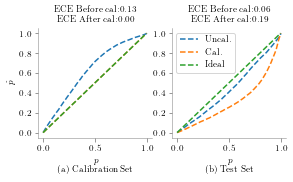

In [40]:


fig, (a,b)=plt.subplots(1,2,sharey='row')

a.plot(p, series_cal.values, label='Uncalibrated', linestyle='dashed')
a.plot(p, new_p_hat_cal, label='Calibrated', linestyle='dashed')
a.plot([0, 1], [0, 1], label="Ideal",linestyle='dashed')
a.set_title(f"ECE Before cal:{ace(p,series_cal.values):.2f}\n ECE After cal:{ace(p,new_p_hat_cal):.2f}")
a.set_ylabel('$\hat{p}$')
b.plot(p, series_test.values, label='Uncal.', linestyle='dashed')
b.plot(p, new_p_hat_test,label='Cal.', linestyle='dashed')
b.plot([0, 1], [0, 1], label="Ideal",linestyle='dashed')
b.set_title(f"ECE Before cal:{ace(p,series_test.values):.2f}\n ECE After cal:{ace(p,new_p_hat_test):.2f}")
# a.text(0.1,-0.5,'(a) Calibration Set')
# b.text(0.3,-0.5,'(b) Test Set')
a.set_xlabel('$p$\n(a) Calibration Set')
b.set_xlabel('$p$\n(b) Test Set')
lgd=plt.legend()
sns.despine()
format_axes(a)
format_axes(b)
# b.set_yticks([])

savefig('badcal',bbox_extra_artists=(lgd,),bbox_inches='tight')